# Spectral correction of camera RGB bands

The purpose of this notebook is to find correction coefficients for the camera RGB bands in order to correct raw files in a way that they can be interpreted as "black-and-white pictures". They can then be used for finding star positions.

These are multiplicative coefficients that we apply to each band (the G band coefficient can be made 1.0) so a star image in a raw file whose bands were so corrected, will have a reasonably smooth profile. And the sky background will also be smooth. That is, the differences in gain between the three bands will be corrected out of the raw file.

Of course, this would work well if not for three complicating factors:
 - the PSF is in general color dependent
 - stars have a variety of spectra
 - the sky background spectrum maybe differ from any star's
 
The idea here is to use the solar spectrum (or a blackbody at 5900K) as reference. The coefficients thus derived will be optimal for stars of type G, and also for the background in cases where it is dominated by day ligth (seldom the case). For other stars and non-daylight backgrounds, we hope to be at least in the ball park.  

In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt

from synphot import SpectralElement, SourceSpectrum, Observation
from synphot.models import Empirical1D, BlackBodyNorm1D

## Read camera RGB curves

In [2]:
fname = 'Sony_curves/Sony_ILCE-7RM2.json'
f = open(fname)
data = json.load(f)

In [3]:
wave = data['ssf_bands']
r_curve = data['red_ssf']
g_curve = data['green_ssf']
b_curve = data['blue_ssf']

print(data['provenance'])

Data from Jack Hogan https://www.dpreview.com/forums/thread/4343781


In [4]:
# convert wavelength from nm to Angstrom
wave = np.array(wave) * 10.

## Build bandpasses

In [5]:
bp_red   = SpectralElement(Empirical1D, points=wave, lookup_table=r_curve, keep_neg=True)
bp_green = SpectralElement(Empirical1D, points=wave, lookup_table=g_curve, keep_neg=True)
bp_blue  = SpectralElement(Empirical1D, points=wave, lookup_table=b_curve, keep_neg=True)

## Build blackbody

In [6]:
bb = SourceSpectrum(BlackBodyNorm1D, temperature=5778.)
# bb = SourceSpectrum(BlackBodyNorm1D, temperature=4300.)

## Convolve and get relative count rates

In [7]:
# convolve
obs_red   = Observation(bb, bp_red) 
obs_green = Observation(bb, bp_green) 
obs_blue  = Observation(bb, bp_blue) 

We need countrate, not energy, because the detector counts electrons. We are making the assumption that the Sony curves already include detector sensitivity.

In [8]:
# get countrates. Units are irrelevant, because we want just the ratio between the bands
cr_red   = obs_red.countrate(area=1.)
cr_green = obs_green.countrate(area=1.)
cr_blue  = obs_blue.countrate(area=1.)

In [9]:
print("Red: ", cr_red / cr_green)
print("Blue: ", cr_blue / cr_green)
print("For unit green")

Red:  0.4385778493463989
Blue:  0.645956777186437
For unit green


## Plot

In [10]:
# resample and normalize blackbody
bb_flux = bb(bp_red.waveset)
bb_flux /= np.max(bb_flux)

/Users/busko/Projects/software/miniconda3_2/envs/raw/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/busko/Projects/software/miniconda3_2/envs/raw/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  after removing the cwd from sys.path.
/Users/busko/Projects/software/miniconda3_2/envs/raw/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  """
/Users/busko/Projects/software/miniconda3_2/envs/raw/lib/python3.7/site-packages/ip

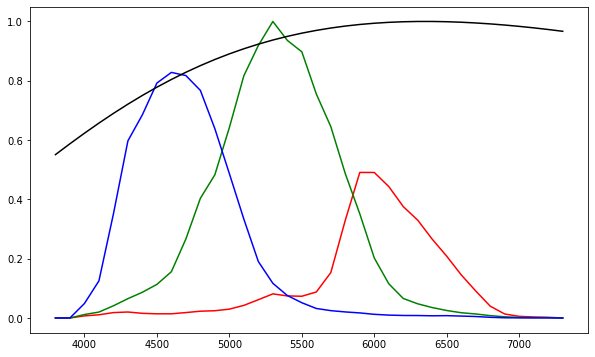

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(bp_red.waveset, bp_red(bp_red.waveset), 'k-', color='r')
ax.plot(bp_green.waveset, bp_green(bp_green.waveset), 'k-', color='g')
ax.plot(bp_blue.waveset, bp_blue(bp_blue.waveset), 'k-', color='b')

ax.plot(bp_red.waveset, bb_flux, 'k-', color='black')